## Event Detector 

Testing ways of extracting short movement events from raw EMG time series.

Ideas: 
- find time points of peak vector norms
- project data into latent space and find peaks there (covariance space) 
    - PCA
    - tangent space 

## Vector Norm Peaks

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [9, 6]
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import numpy as np
import scipy.signal
import scipy.ndimage
import seaborn as sns
import pandas as pd 
from pathlib import Path
from analysis import *

folder = Path("data/200320_spencer")
g = folder.glob('*')
data_files = [x for x in g if x.is_file() and x.suffix=='.data']
# tree(folder)
print("DATA FILES:")
for file in data_files:
    print(f"+ {file}")

DATA FILES:
+ data/200320_spencer/fingers_belowtable_weak.data
+ data/200320_spencer/fingerflexions_2.data
+ data/200320_spencer/strong_grasp.data
+ data/200320_spencer/freeform.data
+ data/200320_spencer/fingers_belowtable_strong.data
+ data/200320_spencer/fingers_abovetable_strong.data
+ data/200320_spencer/fingers_abovetable_weak.data
+ data/200320_spencer/fingerflexions_1.data


max:  0.31062413437499997 min:  -0.38591760781250006
shape:  (64, 225900)


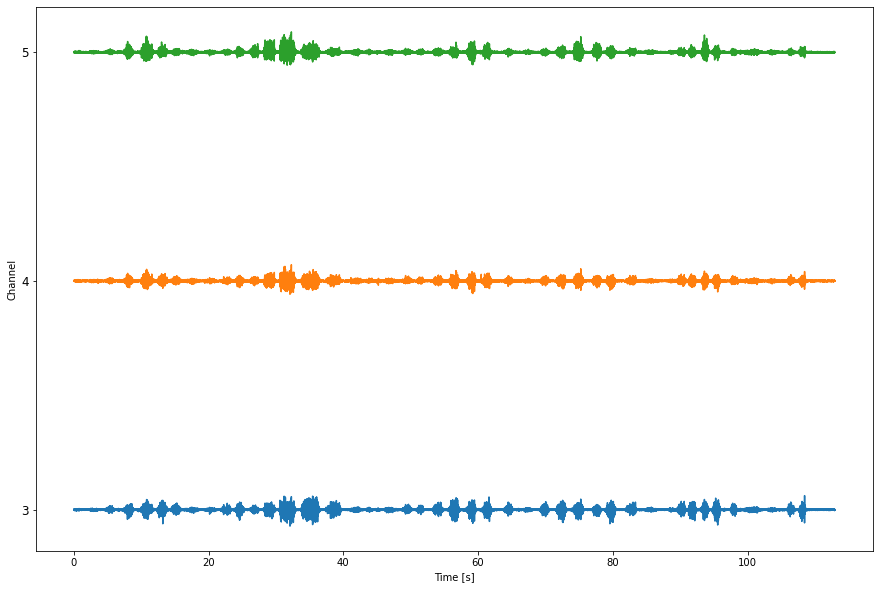

In [2]:
filename = "fingers_belowtable_strong.data"
path = folder / filename
START_SAMPLE = 1000
data = load_from_file(path, nch=68, dtype="int32")[:,START_SAMPLE:]
signals = data[:64]
counter = data[-1]
data_mv = preprocess(signals)
s_fig = plot_biolectric(data_mv, idxs_to_plot=[2,3,4],offset = 1)

(1, 225900)


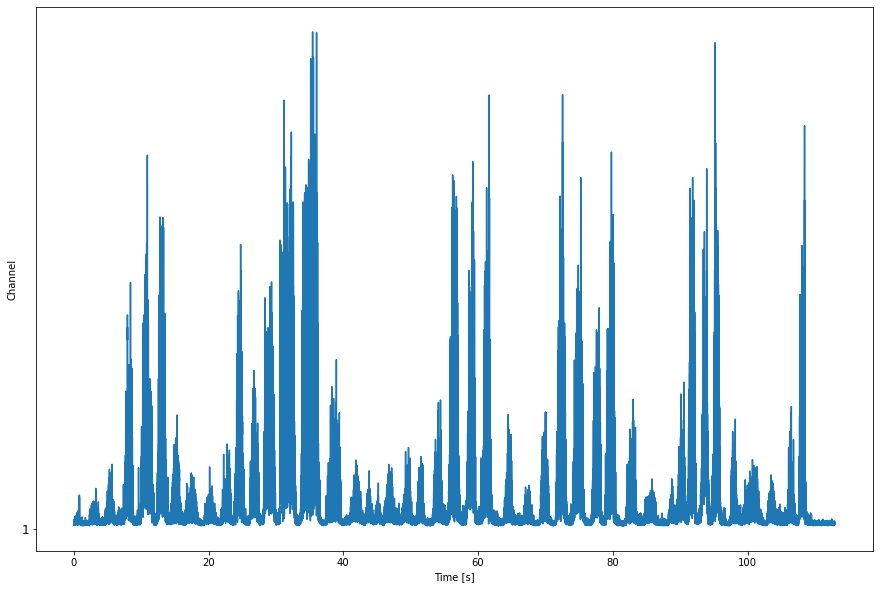

In [3]:
norm = np.linalg.norm(data_mv,axis=0)
print(norm.reshape(1,-1).shape)
fig = plot_biolectric(norm.reshape(1,-1))

Now find peaks in a window around the upper quartile boundary.

### findpeaks

#### xsequence
- A signal with peaks.    

#### height (number or ndarray or sequence, optional)
- Required height of peaks. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required height.

#### threshold (number or ndarray or sequence, optional)
- Required threshold of peaks, the vertical distance to its neighbouring samples. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

#### distance (number, optional)
- Required minimal horizontal distance (>= 1) in samples between neighbouring peaks. Smaller peaks are removed first until the condition is fulfilled for all remaining peaks.

#### prominence (number or ndarray or sequence, optional)
- Required prominence of peaks. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required prominence.

#### width (number or ndarray or sequence, optional)
- Required width of peaks in samples. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required width.

#### wlen (int, optional)
- Used for calculation of the peaks prominences, thus it is only used if one of the arguments prominence or width is given. See argument wlen in peak_prominences for a full description of its effects.

#### rel_height (float, optional)
- Used for calculation of the peaks width, thus it is only used if width is given. See argument rel_height in peak_widths for a full description of its effects.

#### plateau_size (number or ndarray or sequence, optional)
- Required size of the flat top of peaks in samples. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied as the maximal required plateau size.

(1, 225900)


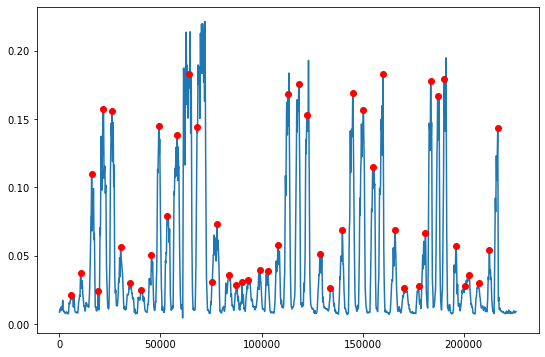

In [43]:
lowpassed = lowpass(norm.reshape(-1,1),cutoff=5).T
# fig = plot_biolectric(lowpassed)
percentile = np.percentile(lowpassed,85)
width = 1000
peak_indices, peak_heights = scipy.signal.find_peaks(lowpassed[0], height=(percentile*.2,percentile*1.8),distance=width*2)
peak_heights = peak_heights['peak_heights']

fig = plt.figure()
ax = fig.add_subplot(111)
print(lowpassed.shape)
ax.plot(lowpassed[0])
ax.plot(peak_indices,peak_heights,'ro')

Cut out the peaks symmetrically 

In [54]:
print(data_mv.shape)
# fig = plt.figure(figsize=(10,50))
# axs = fig.subplots(nrows=len(peak_indices),ncols=1)
event_emg = np.empty(shape=(64,width,len(peak_indices)))
event_lowpassed = np.empty(shape=(len(peak_indices),width))
for ax, peak_idx, i in zip(axs,peak_indices,range(len(peak_indices))):
    event_emg[:,:,i] = data_mv[:,(peak_idx-width//2):(peak_idx+width//2)]
    event_lowpassed[i,:] = lowpassed[0,(peak_idx-width//2):(peak_idx+width//2)]
#     ax.plot(lowpassed[0,(peak_idx-width//2):(peak_idx+width//2)])

(64, 225900)


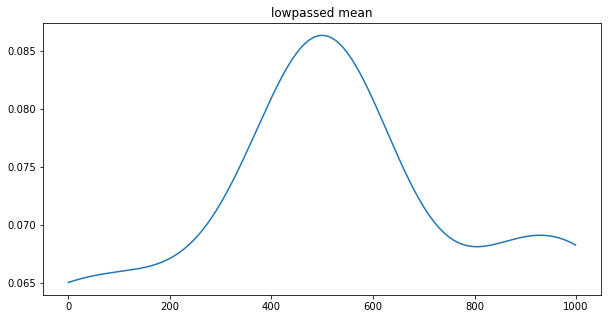

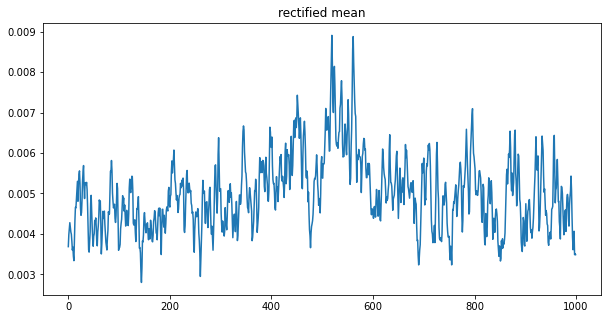

In [58]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.set_title("lowpassed mean")
p = ax.plot(event_lowpassed.mean(axis=0))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.set_title("rectified mean")
p = ax.plot(np.abs(event_emg).mean(axis=2)[3,:])

Pretty decent peak alignment? 

## Notes 
- This works reasonably well, but will be sensitive to artifacts
- The width of the sample needs to be short in order to capture activity on individual channels